In [ ]:
!pip install diffusers["torch"] transformers accelerate
!pip install git+https://github.com/huggingface/diffusers
!pip install einops

In [ ]:
!unzip VOC2012.zip
# !unzip Cityscape.zip
# !unzip Kvasir-SEG.zip
# !unzip Vaihingen.zip

In [ ]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import DDIMScheduler, DDPMWuerstchenScheduler, StableCascadeDecoderPipeline, StableCascadePriorPipeline
import numpy as np
import abc

LOW_RESOURCE = False
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77

# code for store attention
class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):

    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        print("foward", key)
        print("foward", attn.shape)
        print(">>>")
        if attn.shape[1] <= 64 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                print("between steps", key)
                print("between steps", len(self.attention_store[key]))
                print(">>>")
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

In [ ]:
from PIL import Image
import cv2


## Visualization code utils
def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)


def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img

In [ ]:
# code for aggregaring attention
def aggregate_all_attention(prompts, attention_store: AttentionStore, from_where: List[str], is_cross: bool, select: int):
    attention_maps = attention_store.get_average_attention()
    # print(attention_maps.keys())
    att_8 = []
    att_16 = []
    att_32 = []
    att_64 = []
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == 8*8:
                cross_maps = item.reshape(len(prompts), -1, 8, 8, item.shape[-1])[select]
                att_8.append(cross_maps)
            if item.shape[1] == 16*16:
                cross_maps = item.reshape(len(prompts), -1, 16, 16, item.shape[-1])[select]
                att_16.append(cross_maps)
            if item.shape[1] == 32*32:
                cross_maps = item.reshape(len(prompts), -1, 32, 32, item.shape[-1])[select]
                att_32.append(cross_maps)
            if item.shape[1] == 64*64:
                cross_maps = item.reshape(len(prompts), -1, 64, 64, item.shape[-1])[select]
                att_64.append(cross_maps)
            # else:
            #   print(item.shape[1])
    print(len(att_8), len(att_16), len(att_32), len(att_64)) # base: 0, 60, 10, 0, refiner: 4, 20, 20, 0
    atts = []
    for att in [att_8, att_16, att_32, att_64]:
        if len(att) == 0:
          continue
        att = torch.cat(att, dim=0)
        att = att.sum(0) / att.shape[0]
        atts.append(att.cpu())
    return atts


def aggregate_attention(prompts, attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


# visualize cross att
def show_cross_attention(prompts, tokenizer, attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(prompts, attention_store, res, from_where, True, select)
    images = []
    j = 0
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.float().numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        if decoder(int(tokens[j])) == "++":
            j += 1
        image = text_under_image(image, decoder(int(tokens[j])))
        images.append(image)
        j+=1
        if j >= len(tokens):
            break
    view_images(np.stack(images, axis=0))


# visualize self att
def show_self_attention_comp(prompts, attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(prompts, attention_store, res, from_where, False, select).float().numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    view_images(np.concatenate(images, axis=1))

In [ ]:
def encode_imgs(imgs, decoder):
    # imgs: [B, 3, H, W]
    # imgs = 2 * imgs - 1
    # posterior = vae.encode(imgs).latent_dist.mean
    # # print('posterior in encode_imgs', posterior)
    # latents = posterior * 0.18215
    latents = decoder.vqgan.encode(imgs).latents
    # print(latents.shape) # [1, 4, 128, 128]
    return latents


# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)  # 固定随机种子（CPU）
    if torch.cuda.is_available():  # 固定随机种子（GPU)
        torch.cuda.manual_seed(seed)  # 为当前GPU设置
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置
    np.random.seed(seed)  # 保证后续使用random函数时，产生固定的随机数
    torch.backends.cudnn.benchmark = False  # GPU、网络结构固定，可设置为True
    torch.backends.cudnn.deterministic = True  # 固定网络结构


# cam visual_code
def show_cam_on_image(img, mask):
    mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(img.size[1],img.size[0]), mode='bilinear', align_corners=False).squeeze().squeeze()
    img = np.float32(img) / 255.
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + img
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    return cam

In [ ]:
## ptp utils function
from einops import rearrange
from math import ceil

def init_latent_prior(latent, model, height, width, generator, batch_size):
    latents_shape = (
      batch_size,
      model.prior.config.in_channels,
      ceil(height / model.config.resolution_multiple),
      ceil(width / model.config.resolution_multiple),
    )
    if latent is None:
      latents = torch.randn(
            latents_shape,
            generator=generator,
            device=model.device,
            dtype=model.dtype
        )
    else:
      if latent.shape != latents_shape:
        raise ValueError(f"Unexpected latents shape, got {latent.shape}, expected {latents_shape}")
      latents = latents.to(model.device)

    latents = latents * model.scheduler.init_noise_sigma
    return latent, latents


def init_latent_decoder(latents, model, image_embeddings, generator, batch_size):
  _, channels, height, width = image_embeddings.shape
  latents_shape = (
      batch_size,
      4,
      int(height * model.config.latent_dim_scale),
      int(width * model.config.latent_dim_scale),
  )
  if latents is None:
    latents = torch.randn(latents_shape, generator=generator, device=model.device, dtype=model.dtype)
  else:
    if latents.shape != latents_shape:
      raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
    latents = latents.to(model.device)
  return latents


def register_attention_control(model, controller, prior=True):
    def ca_forward(self, place_in_unet):
        # to_out = self.to_out
        # if type(to_out) is torch.nn.modules.container.ModuleList:
        #     to_out = self.to_out[0]
        # else:
        #     to_out = self.to_out

        def forward(x, kv):

            kv = self.kv_mapper(kv)
            norm_x = self.norm(x)
            if self.self_attn:
              batch_size, channel, _, _ = x.shape
              kv = torch.cat([norm_x.view(batch_size, channel, -1).transpose(1, 2), kv], dim=1)

            sim = self.attention(norm_x, encoder_hidden_states=kv)
            print(x.shape) # torch.Size([2, 1280, 16, 16])
            print(sim.shape) # torch.Size([2, 1280, 16, 16])
            attn = sim.softmax(dim=-1)
            attn = controller(attn, not self.self_attn, place_in_unet)

            return x + sim

        return forward

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == 'SDCascadeAttnBlock':
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    sub_nets = model.prior.named_children() if prior else model.decoder.named_children()
    for net in sub_nets:
        if "down" in net[0]:
            # print(net[0])
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            # print(net[0])
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            # print(net[0])
            cross_att_count += register_recr(net[1], 0, "mid")

    controller.num_att_layers = cross_att_count


def diffusion_step_decoder(model, latents, context, t):
  dtype = model.decoder.dtype
  (
      prompt_embeds_pooled,
      effnet
  ) = context

  timestep_ratio = t.expand(latents.size(0)).to(dtype)

  predicted_latents = model.decoder(
    sample=torch.cat([latents] * 2),
    timestep_ratio=torch.cat([timestep_ratio] * 2),
    clip_text_pooled=prompt_embeds_pooled,
    effnet=effnet,
    return_dict=False,
  )[0]


def encode_prompt(
    model,
    prompt,
    batch_size
):
  text_inputs = model.tokenizer(
    prompt,
    padding="max_length",
    max_length=model.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
  )
  text_input_ids = text_inputs.input_ids
  attention_mask = text_inputs.attention_mask
  text_encoder_output = model.text_encoder(
    text_input_ids.to(device), attention_mask=attention_mask.to(device), output_hidden_states=True
  )
  prompt_embeds = text_encoder_output.hidden_states[-1]
  prompt_embeds_pooled = text_encoder_output.text_embeds.unsqueeze(1)

  prompt_embeds = prompt_embeds.to(dtype=model.text_encoder.dtype, device=device)
  prompt_embeds_pooled = prompt_embeds_pooled.to(dtype=model.text_encoder.dtype, device=device)
  prompt_embeds = prompt_embeds.repeat_interleave(1, dim=0)
  prompt_embeds_pooled = prompt_embeds_pooled.repeat_interleave(1, dim=0)

  uncond_tokens = [""] * batch_size
  uncond_input = model.tokenizer(
    uncond_tokens,
    padding="max_length",
    max_length=model.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
  )
  negative_prompt_embeds_text_encoder_output = model.text_encoder(
      uncond_input.input_ids.to(device),
      attention_mask=uncond_input.attention_mask.to(device),
      output_hidden_states=True,
  )
  negative_prompt_embeds = negative_prompt_embeds_text_encoder_output.hidden_states[-1]
  negative_prompt_embeds_pooled = negative_prompt_embeds_text_encoder_output.text_embeds.unsqueeze(1)

  # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
  seq_len = negative_prompt_embeds.shape[1]
  negative_prompt_embeds = negative_prompt_embeds.to(dtype=model.text_encoder.dtype, device=device)
  negative_prompt_embeds = negative_prompt_embeds.repeat(1, 1, 1)
  negative_prompt_embeds = negative_prompt_embeds.view(batch_size, seq_len, -1)

  seq_len = negative_prompt_embeds_pooled.shape[1]
  negative_prompt_embeds_pooled = negative_prompt_embeds_pooled.to(
    dtype=model.text_encoder.dtype, device=device
  )
  negative_prompt_embeds_pooled = negative_prompt_embeds_pooled.repeat(1, 1, 1)
  negative_prompt_embeds_pooled = negative_prompt_embeds_pooled.view(
    batch_size, seq_len, -1
  )
  return prompt_embeds, prompt_embeds_pooled, negative_prompt_embeds, negative_prompt_embeds_pooled


def encode_image(model, images, device, dtype, batch_size):
  image_embeds = []
  for image in images:
    image = model.feature_extractor(image, return_tensors="pt").pixel_values
    image = image.to(device=device, dtype=dtype)
    image_embed = model.image_encoder(image).image_embeds.unsqueeze(1)
    image_embeds.append(image_embed)
    image_embeds = torch.cat(image_embeds, dim=1)

    image_embeds = image_embeds.repeat(batch_size, 1, 1)
    negative_image_embeds = torch.zeros_like(image_embeds)

    return image_embeds, negative_image_embeds


## text to image custom pipeline
@torch.no_grad()
def text2image_ldm_stable(
    decoder,
    prompt: List[str],
    controller,
    prior_outputs,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    noise_sample_num=1,
    height: int = 512,
    width: int = 512,
):

  # 0. Define commonly used variables
  register_attention_control(decoder, controller, prior=False)
  height = height
  width = width
  batch_size = len(prompt)
  device = decoder.decoder.device

  image_embeddings = prior_outputs.image_embeddings
  # decoder_output = decoder(
  #   image_embeddings=image_embeddings,
  #   prompt=prompt,
  #   guidance_scale=0.0,
  #   output_type="pil",
  #   num_inference_steps=10
  # ).images[0]

  # decoder.check_inputs(prompt, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_prompt_embeds)
  if isinstance(image_embeddings, list):
    print('>>> here')
    image_embeddings = torch.cat(image_embeddings, dim=0)
  _, prompt_embeds_pooled, _, negative_prompt_embeds_pooled = encode_prompt(
    decoder,
    prompt,
    batch_size
  )
  prompt_embeds_pooled = (torch.cat([prompt_embeds_pooled, negative_prompt_embeds_pooled]))
  effnet = (torch.cat([image_embeddings, torch.zeros_like(image_embeddings)]))

  decoder.scheduler.set_timesteps(num_inference_steps, device=device)
  timesteps = decoder.scheduler.timesteps

  latents = init_latent_decoder(latent, decoder, image_embeddings, generator, batch_size)
  print("latents", latents.shape)
  print("prompt embeds pooled", prompt_embeds_pooled.shape)
  print("effnet", effnet.shape)
  decoder._num_timesteps = len(timesteps[:-1])
  for i, t in enumerate(decoder.progress_bar(timesteps[:-1])):
    timestep_ratio = t.expand(latents.size(0)).to(decoder.dtype)

    predicted_latents = decoder.decoder(
      sample=torch.cat([latents] * 2),
      timestep_ratio=torch.cat([timestep_ratio] * 2),
      clip_text_pooled=prompt_embeds_pooled,
      effnet=effnet,
      return_dict=False,
    )[0]
    break

  return None, None

ModuleNotFoundError: No module named 'einops'

In [ ]:
import torch.nn.functional as F

# main function
# Stable diffusion
def generate_att(t, prior, decoder, input_latent, imgs, noise, prompts, controller, pos, device, is_self=True, is_multi_self=False, is_cross_norm=True, prior_weight=[0.8, 0.2], decoder_weight=[0.8, 0.2], height=None, width=None, verbose=False):
    ## pos: position of the target class word int he prompt
    controller.reset()
    g_cpu = torch.Generator(4307)
    latents_noisy = decoder.scheduler.add_noise(input_latent, noise, torch.tensor(t, device=device))
    prior_outputs = prior(
      prompt=prompts,
      images=[img.float() for img in imgs],
      height=height,
      width=width,
      num_inference_steps=10,
      guidance_scale=GUIDANCE_SCALE,
      num_images_per_prompt=1,
      generator=g_cpu,
      output_type="pt",
      return_dict=True,
    )
    images, x_t = text2image_ldm_stable(decoder, prompts, controller, prior_outputs, latent=latents_noisy, num_inference_steps=t, guidance_scale=GUIDANCE_SCALE, generator=g_cpu, height=height, width=width)
    layers = ("mid", "up", "down")
    cross_attention_maps_1 = aggregate_all_attention(prompts, controller, layers, True, 0)
    for map in cross_attention_maps_1:
      print(map.shape)
    self_attention_maps_1 = aggregate_all_attention(prompts, controller, ("up", "mid", "down"), False, 0)
    for map in self_attention_maps_1:
      print(map.shape)

    imgs = []
    resolution_range = [16, 32]
    if not base:
      resolution_range = [8, 16, 32]
    for idx, res in enumerate(resolution_range):
        out_att = cross_attention_maps[idx].permute(2,0,1).float()
        if is_cross_norm:
            att_max = torch.amax(out_att, dim=(1,2), keepdim=True)
            att_min = torch.amin(out_att, dim=(1,2), keepdim=True)
            out_att = (out_att - att_min) / (att_max - att_min)
        if is_multi_self:
            self_att = self_attention_maps[idx].view(res * res, res * res).float()
            self_att = self_att / self_att.max()
            out_att = torch.matmul(self_att.unsqueeze(0),out_att.view(-1,res*res,1)).view(-1,res,res)
        if res != resolution_range[-1]:
            out_att = F.interpolate(out_att.unsqueeze(0), size=(resolution_range[-1], resolution_range[-1]), mode='bilinear', align_corners=False).squeeze()
        ## 16*16: 0.8, 32*32: 0.2
        imgs.append(out_att * weight[idx])

    # aggregated cross attention map
    cross_att_map = torch.stack(imgs).sum(0)[pos].mean(0).view(resolution_range[-1]*resolution_range[-1], 1)
    # refine cross attention map with self attention map
    if is_self and not is_multi_self:
        self_att = self_attention_maps[-1].view(resolution_range[-1]*resolution_range[-1],resolution_range[-1]*resolution_range[-1]).float()
        self_att = self_att / self_att.max()
        for i in range(1):
            cross_att_map = torch.matmul(self_att, cross_att_map)
    # res here is the highest resulution iterated in previous for loop, 64
    att_map = cross_att_map.view(res, res)
    att_map = F.interpolate(att_map.unsqueeze(0).unsqueeze(0), size=(512,512), mode='bilinear', align_corners=False).squeeze().squeeze()
    att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min())
    att_map = F.sigmoid(8 * (att_map - 0.4))
    att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min())
    if verbose:
      att_map_map = Image.fromarray((att_map.cpu().detach().numpy() * 255).astype(np.uint8),mode="L")
      display(att_map_map)
      tokenizer = ldm_stable.tokenizer if ldm_stable.tokenizer is not None else ldm_stable.tokenizer_2
      for res in resolution_range:
        print("{}x{} cross att map".format(res, res))
        show_cross_attention(prompts, tokenizer, controller, res=res, from_where=layers)

    return att_map

In [ ]:
from torchvision import transforms

def stable_diffusion_inference(img_path, cls_name, device, blip_device, processor, model, prior, decoder, verbose=False, prior_weight=[0.8, 0.2], decoder_weight=[0.8, 0.2], prompt=None):
  ## img_path: path to the target image
  ## cls name: taget class in the prompt
  ## device: device of stable diffusion model
  ## blip device: device of BLIP model
  ## processor: BLIP processot
  ## model: BLIP model
  ## vae: vae of the stable diffusion model
  with torch.no_grad():
    same_seeds(3407)

    input_img = Image.open(img_path).convert("RGB")

    trans = []
    trans.append(transforms.ToTensor())
    trans = transforms.Compose(trans)

    img_tensor = (trans(input_img).unsqueeze(0)).to(device)
    rgb_512 = F.interpolate(img_tensor, (512, 512), mode='bilinear', align_corners=False).bfloat16()
    # rgb_512 = F.interpolate(img_tensor, (512, 512), mode='bilinear', align_corners=False).bfloat16()

    # input_latent = encode_imgs(rgb_512, prior)
    input_latent = encode_imgs(rgb_512, decoder)
    # print('input latent', input_latent)
    noise = torch.randn_like(input_latent).to(device)
    raw_image = input_img
    if prompt is None:
      text = f"a photograph of {cls_name}"
      inputs = processor(raw_image, text, return_tensors="pt").to(blip_device) # processor: Blip processor

      # use blip and "++" emphasizing semantic information of target categories
      out = model.generate(**inputs)
      texts = processor.decode(out[0], skip_special_tokens=True)
      texts = text +"++"+ texts[len(text):] # ", highly realistic, artsy, trending, colorful"
    else:
      texts = prompt

    # weight is the weight of different layer's cross attn
    # pos is the position of target class word in the sentence, in "a photograph of plane" (plane)'s position is 4
    # t is the denoising step, usually set between 50 to 150
    prompts = [texts]
    print("**** blip_prompt: "+texts+"****")
    pos = [4]   # pos of targer class word
    t = 100
    controller = AttentionStore()
    height = 512
    width = 512
    mask = generate_att(t, prior, decoder, input_latent, [rgb_512], noise, prompts, controller, pos, device, is_self=True, is_multi_self=False, is_cross_norm=True, prior_weight=prior_weight, decoder_weight=decoder_weight, height=height, width=width, verbose=verbose)
    mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(raw_image.size[1],raw_image.size[0]), mode='bilinear', align_corners=False).squeeze().squeeze()
    # print(mask.shape, raw_image.size)
    if verbose:
      cam = show_cam_on_image(raw_image, mask)
      print("visual_cam")
      display(Image.fromarray(cam[:,:,::-1]))
    del img_tensor
    del rgb_512
    del noise
    if prompt is None:
      del inputs
    torch.cuda.empty_cache()
    return mask, texts

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
prior_key = "stabilityai/stable-cascade-prior"
decoder_key = "stabilityai/stable-cascade"
prior = StableCascadePriorPipeline.from_pretrained(prior_key, variant="bf16", torch_dtype=torch.bfloat16).to(device)
decoder = StableCascadeDecoderPipeline.from_pretrained(decoder_key, variant="bf16", torch_dtype=torch.bfloat16).to(device)

# prior.scheduler = DDIMScheduler.from_pretrained(prior_key, subfolder="scheduler",
#                                                      beta_start=0.00085,beta_end=0.012,
#                                                      steps_offset=1)

decoder.scheduler = DDIMScheduler.from_pretrained(decoder_key, subfolder="scheduler",
                                                     beta_start=0.00085,beta_end=0.012,
                                                     steps_offset=1)
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_device = "cuda:0"
# blip device
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(blip_device)

model_index.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

prior/config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

diffusion_pytorch_model.bf16.safetensors:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.bf16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.bf16.safetensors:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

model.bf16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

diffusion_pytorch_model.bf16.safetensors:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

decoder/config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.bf16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.bf16.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

vqgan/config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

diffusion_pytorch_model.bf16.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [ ]:
import os
import shutil
import time

import json
import time, os, shutil

VOC_label_map = {
  1:'aeroplane',
  2:'bicycle',
  3:'bird',
  4:'boat',
  5:'bottle',
  6:'bus',
  7:'car',
  8:'cat',
  9:'chair',
  10:'cow',
  11:'diningtable',
  12:'dog',
  13:'horse',
  14:'motorbike',
  15:'person',
  16:'pottedplant',
  17:'sheep',
  18:'sofa',
  19:'train',
  20:'tvmonitor'
}

Cityscape_label_map = {
    1: 'road', # flat
    2: 'person', # human
    3: 'building', # construction
    4: 'traffic light', # object
    5: 'vegetation', # nature
    6: 'car', # vehicle
    7: 'bus', # vehicle
    8: 'train', # vehicle
    9: 'motorcycle', # vehicle
    10: 'bicycle', #vehicle
}

Vaihingen_label_map = {
  1: 'building'
}

Kvasir_label_map = {
  1: 'tumor'
}

def domain_test(images_dir, result_dir, label_map, augmented_label_file, prior_weight, decoder_weight, augmented_label=False, thres_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  start = time.time()
  if os.path.isdir(result_dir):
    shutil.rmtree(result_dir)
  os.mkdir(result_dir)
  os.mkdir(os.path.join(result_dir, 'mask'))
  for thres in thres_list:
    os.mkdir(os.path.join(result_dir, '{}'.format(thres)))
  cls_arr_dir = images_dir.replace("images", "class_array")
  augmented_label_path = images_dir.replace("images", augmented_label_file)
  # segmentations_dir = images_dir.replace("images", "segmentations")
  with open(augmented_label_path, 'r') as f:
    label_data = json.load(f)

  for img_file in os.listdir(images_dir):
    if not(img_file.endswith('.png') or img_file.endswith('.tif') or img_file.endswith('.jpg')):
      continue
    img_path = os.path.join(images_dir, img_file)
    print(">>> ", img_path)
    seg_classes = label_data[img_path]

    for cls_name in seg_classes.keys():
      mask, prompt = stable_diffusion_inference(img_path, cls_name, device, blip_device, processor, model, prior, decoder, verbose=False, prior_weight=prior_weight, decoder_weight=decoder_weight)
      # cam = show_cam_on_image(Image.open(img_path), mask)
      # print("visual_cam final")
      # display(Image.fromarray(cam[:,:,::-1]))
      with open(os.path.join(result_dir, 'mask', '{}_{}.npy'.format(img_file.split('.')[0], cls_name)), 'wb') as f:
        np.save(f, mask)
      for mask_threshold in thres_list:
        mask_binary = np.where(mask > mask_threshold, 255, 0)
        mask_binary_img = Image.fromarray(mask_binary.astype(np.uint8))
        mask_binary_img.save(os.path.join(result_dir, '{}'.format(mask_threshold), '{}_{}.png'.format(img_file.split('.')[0], cls_name)))

      if augmented_label:
        for aug_cls_name in seg_classes[cls_name]:
          mask, prompt = stable_diffusion_inference(img_path, aug_cls_name, device, blip_device, processor, model, prior, decoder, verbose=False, prior_weight=prior_weight, decoder_weight=decoder_weight)
          with open(os.path.join(result_dir, 'mask', '{}_{}.npy'.format(img_file.split('.')[0], aug_cls_name)), 'wb') as f:
            np.save(f, mask)
          for mask_threshold in thres_list:
            mask_binary = np.where(mask > mask_threshold, 255, 0)
            mask_binary_img = Image.fromarray(mask_binary.astype(np.uint8))
            mask_binary_img.save(os.path.join(result_dir, '{}'.format(mask_threshold), '{}_{}.png'.format(img_file.split('.')[0], aug_cls_name)))
    break
  print(">>>>>>>>>> test time: {:.2f}s".format(time.time() - start))


# datasets = ["VOC2012", "Cityscape", "Vaihingen", "Kvasir-SEG"]
# label_maps = [VOC_label_map, Cityscape_label_map, Vaihingen_label_map, Kvasir_label_map]
datasets = ["VOC2012"]
label_maps = [VOC_label_map]
root_dir = "results_0.9"
augmented_label = True
prior_weight=[0.8, 0.2]
decoder_weight = [0.3, 0.5, 0.2]
if os.path.isdir(root_dir):
  shutil.rmtree(root_dir)
os.mkdir(root_dir)
augmented_label_file = 'aug_label_blip_bert_0.9.json'
for ds, label_map in zip(datasets, label_maps):
   images_dir = os.path.join(ds, "images")
   result_dir = os.path.join(root_dir, ds)
   domain_test(images_dir, result_dir, label_map, augmented_label_file, prior_weight, decoder_weight, augmented_label=augmented_label, thres_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


>>>  VOC2012/images/165.png


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


**** blip_prompt: a photograph of train++ cars parked on the tracks near a building****


  0%|          | 0/10 [00:00<?, ?it/s]

latents torch.Size([1, 4, 128, 128])
prompt embeds pooled torch.Size([2, 1, 1280])
effnet torch.Size([2, 16, 12, 12])


  0%|          | 0/99 [00:00<?, ?it/s]

foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_self
foward torch.Size([1, 1280, 16, 16])
>>>
foward down_se

IndexError: list index out of range

In [ ]:
import shutil
shutil.rmtree("VOC2012")

In [ ]:
decoder

StableCascadeDecoderPipeline {
  "_class_name": "StableCascadeDecoderPipeline",
  "_diffusers_version": "0.28.0.dev0",
  "_name_or_path": "stabilityai/stable-cascade",
  "decoder": [
    "diffusers",
    "StableCascadeUNet"
  ],
  "latent_dim_scale": 10.67,
  "scheduler": [
    "diffusers",
    "DDPMWuerstchenScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizerFast"
  ],
  "vqgan": [
    "wuerstchen",
    "PaellaVQModel"
  ]
}

In [ ]:
decoder.decoder

StableCascadeUNet(
  (effnet_mapper): Sequential(
    (0): Conv2d(16, 1280, kernel_size=(1, 1), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(1280, 320, kernel_size=(1, 1), stride=(1, 1))
    (3): SDCascadeLayerNorm((320,), eps=1e-06, elementwise_affine=False)
  )
  (pixels_mapper): Sequential(
    (0): Conv2d(3, 1280, kernel_size=(1, 1), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(1280, 320, kernel_size=(1, 1), stride=(1, 1))
    (3): SDCascadeLayerNorm((320,), eps=1e-06, elementwise_affine=False)
  )
  (clip_txt_pooled_mapper): Linear(in_features=1280, out_features=5120, bias=True)
  (clip_norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=False)
  (embedding): Sequential(
    (0): PixelUnshuffle(downscale_factor=2)
    (1): Conv2d(16, 320, kernel_size=(1, 1), stride=(1, 1))
    (2): SDCascadeLayerNorm((320,), eps=1e-06, elementwise_affine=False)
  )
  (down_blocks): ModuleList(
    (0): ModuleList(
      (0): SDCascadeResBlock(
        (d

In [ ]:
decoder.decoder.config

FrozenDict([('in_channels', 4),
            ('out_channels', 4),
            ('timestep_ratio_embedding_dim', 64),
            ('patch_size', 2),
            ('conditioning_dim', 1280),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('num_attention_heads', [0, 0, 20, 20]),
            ('down_num_layers_per_block', [2, 6, 28, 6]),
            ('up_num_layers_per_block', [6, 28, 6, 2]),
            ('down_blocks_repeat_mappers', [1, 1, 1, 1]),
            ('up_blocks_repeat_mappers', [3, 3, 2, 2]),
            ('block_types_per_layer',
             [['SDCascadeResBlock', 'SDCascadeTimestepBlock'],
              ['SDCascadeResBlock', 'SDCascadeTimestepBlock'],
              ['SDCascadeResBlock',
               'SDCascadeTimestepBlock',
               'SDCascadeAttnBlock'],
              ['SDCascadeResBlock',
               'SDCascadeTimestepBlock',
               'SDCascadeAttnBlock']]),
            ('clip_text_in_channels', None),
            ('clip_text_pooled_i

In [ ]:
decoder.vqgan.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('up_down_scale_factor', 2),
            ('levels', 2),
            ('bottleneck_blocks', 12),
            ('embed_dim', 384),
            ('latent_channels', 4),
            ('num_vq_embeddings', 8192),
            ('scale_factor', 0.3764),
            ('_class_name', 'PaellaVQModel'),
            ('_diffusers_version', '0.27.0.dev0'),
            ('_name_or_path',
             '/root/.cache/huggingface/hub/models--stabilityai--stable-cascade/snapshots/a89f66d459ae653e3b4d4f992a7c3789d0dc4d16/vqgan')])

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 16, 24, 24])
cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

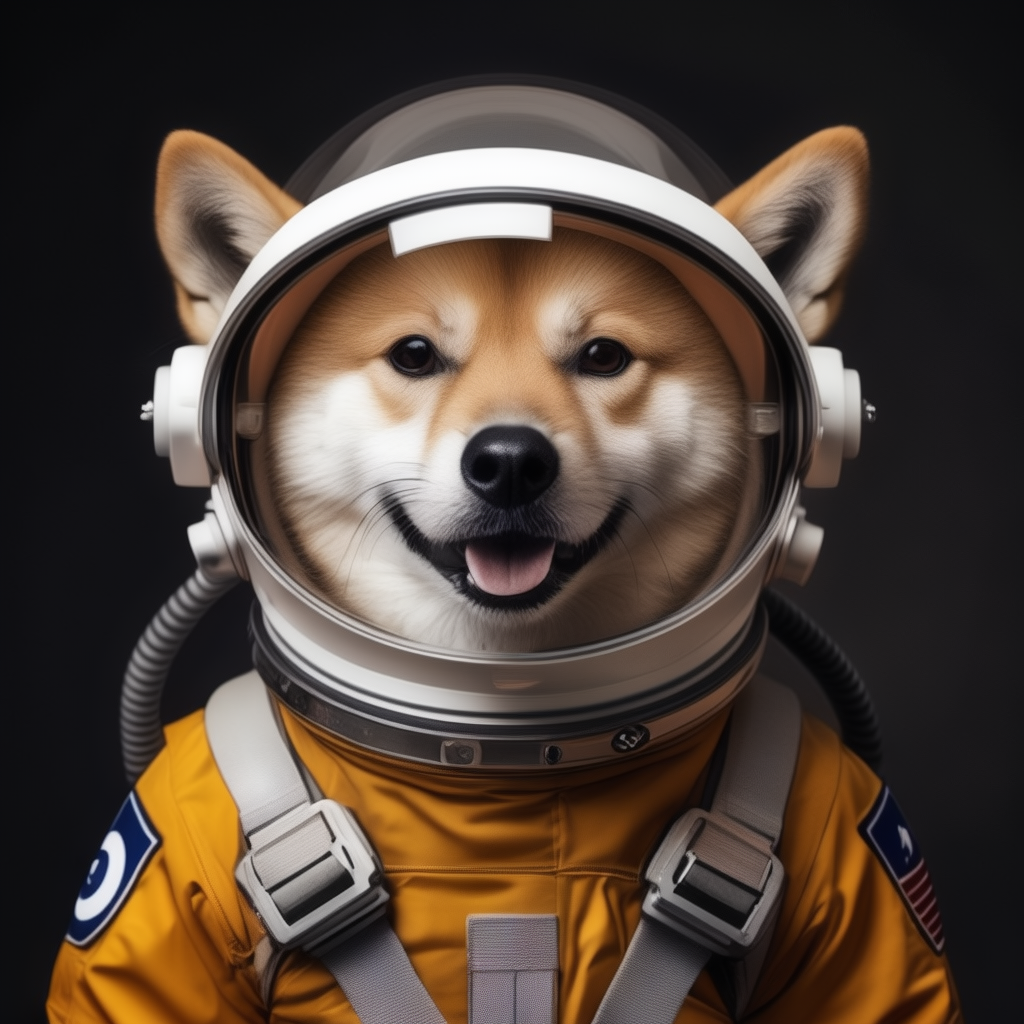

In [ ]:
prompt = "an image of a shiba inu, donning a spacesuit and helmet"

prior_output = prior(
    prompt=prompt,
    height=1024,
    width=1024,
    negative_prompt="",
    guidance_scale=4.0,
    num_images_per_prompt=1,
    num_inference_steps=20
)
print(prior_output.image_embeddings.shape)
print(prior_output.image_embeddings.device)
decoder_output = decoder(
    image_embeddings=prior_output.image_embeddings.to(torch.float16),
    prompt=prompt,
    negative_prompt="",
    guidance_scale=0.0,
    output_type="pil",
    num_inference_steps=10
).images[0]
# print(decoder_output.shape)
display(decoder_output)